In [22]:
def importdata():
    df = pd.read_csv('../data/df_points_2019_final.csv')
    df = df[['bike_id','lat','lng','timestood','time_start','time_end','flag','hex_id']]
    
    df['time_start'] = pd.to_datetime(df['time_start'])
    
    return df

In [23]:
def create_onedf_hexid(df,hex_id):
    onedfhexid = pd.DataFrame(columns= ['bike_id','lat','lng','timestood','time_start','time_end','flag','hex_id'])
    for ind in df.index:
        if df['hex_id'][ind] == hex_id:
            onedfhexid.loc[df.index[ind]] = df.iloc[ind]
            #onedfhexid.append(df[ind], ignore_index = True)
    return onedfhexid.reset_index(drop=True)

In [24]:
def create_tsdata():
    rng = pd.date_range('2019-01-01', periods=365, freq='D')
    tsdata = pd.DataFrame({ 'date': rng, 'idle_time' : np.nan, 'list': np.nan, 'bike_count': np.nan}) 
    return tsdata.set_index('date')

In [66]:
def add_rows_to_days(tsdata,onedfhexid):
    # iteriere über alle Tage
    for date in tqdm(tsdata.index):
        list = []
        # Adde alle Rows in die List wenn Tag = Tag
        for ind in onedfhexid.index:
            if date.date() == onedfhexid['time_start'][ind].date():
                list.append(onedfhexid['timestood'][ind])
        #print(len(list))        
        # Setze Mittelwert für Tage
        if len(list) == 0:
            tsdata['bike_count'][date] = 0
            continue
        else:
            tsdata['bike_count'][date] = len(list)
            tsdata['idle_time'][date] = statistics.mean(list)
    return tsdata

In [59]:
def get_rows_one_day(day,onedfhexid):
    list=[]
    for ind in onedfhexid.index:
        if day == onedfhexid['time_start'][ind].date():
            list.append(onedfhexid['timestood'][ind])
    print(list)
    print(statistics.mean(list))

In [126]:
def roling_mean_out_of_points(tsdata):
    x = []
    rng2 = pd.date_range('2019-01-01', periods=365, freq='D')
    data_mean2 = pd.DataFrame({ 'date': rng2, 'idle_time' : np.nan})
    data_mean2 = data_mean2.set_index('date')
    
    for window in tsdata.rolling(window = 7 , center = True):
        #print(window)
        x.append(np.average(window['idle_time'], weights=window['bike_count']))
    
    data_mean2['idle_time'] = x
    return data_mean2

In [60]:
def plot(x):
    fig, ax1 = plt.subplots(figsize = (20,10))
    
    ax1.plot(x['idle_time'], linewidth=2,color='red', label='Idle Time Mean')
    ax1.set_xlabel('day')
    ax1.set_ylabel('timestood (min)')
    ax1.tick_params(axis ='y', labelcolor = 'red') 
    
    ax2 = ax1.twinx()
    ax2.plot(x['bike_count'], linewidth=2, label='bike_count')
    ax2.set_ylabel('bike_count')
    ax2.tick_params(axis ='y', labelcolor = 'blue')
    
    plt.show()

In [133]:
def plot_details(tsdata,data_7d_rol,data_2m_rol,data_7d_mean2,hex_id):
    fig, ax = plt.subplots(figsize = (20,10))
    
    # plotting daily data
    ax.plot(tsdata['idle_time'], marker='.', markersize=2, color='0.6',linestyle='None', label='Daily')
    # plotting 7-day rolling data
    ax.plot(data_7d_rol['idle_time'],color = 'blue', linewidth=2, label='7-d Rolling Mean')
    ax.plot(data_7d_mean2['idle_time'],color = 'green', linewidth=2, label='7-d Rolling Mean')
    # plotting 2-Month rolling data -trend-
    ax.plot(data_2m_rol['idle_time'], color='0.2', linewidth=3, label='Trend (2M)')
    ax.legend()
    ax.set_xlabel('day')
    ax.set_ylabel('timestood (min)')
    ax.set_title(f'Trends in idel time of bikes in hex: {hex_id}')
    
    ax2 = ax.twinx()
    ax2.plot(data_7d_rol['bike_count'],linewidth=1, color='0.5',label='Bike Count 7-d RM')
    ax2.set_xlabel('day')
    ax2.set_ylabel('bikes in hex per day')
    ax2.legend()
    
    plt.show()

In [131]:
def fix_missing_values(tsdata):
    data_freq = tsdata.asfreq('D')
    data_freq = data_freq.ffill()
    return data_freq

# Main

In [80]:
import pandas as pd
pd.options.mode.chained_assignment = None
from tqdm import tqdm
from datetime import timedelta, datetime, date
pd.set_option('display.max_rows', None)
import weightedstats

import numpy as np
import statistics
import matplotlib.pyplot as plt

### Define the HEX_id

hex_id = '8a1f1a8d9d97fff'
#hex_id = '8a1f1a8cb4cffff'
#hex_id = '8a1f1a8cb4dffff'
#hex_id = '8a1f1a8cb71ffff'

data_columns = ['idle_time','bike_count']

df = importdata()
onedfhexid = create_onedf_hexid(df,hex_id)
tsdata = create_tsdata()
tsdata = add_rows_to_days(tsdata,onedfhexid)
#fix missing values with ffill

100%|███████████████████████████████████████████████████████████████████| 365/365 [00:44<00:00,  8.19it/s]


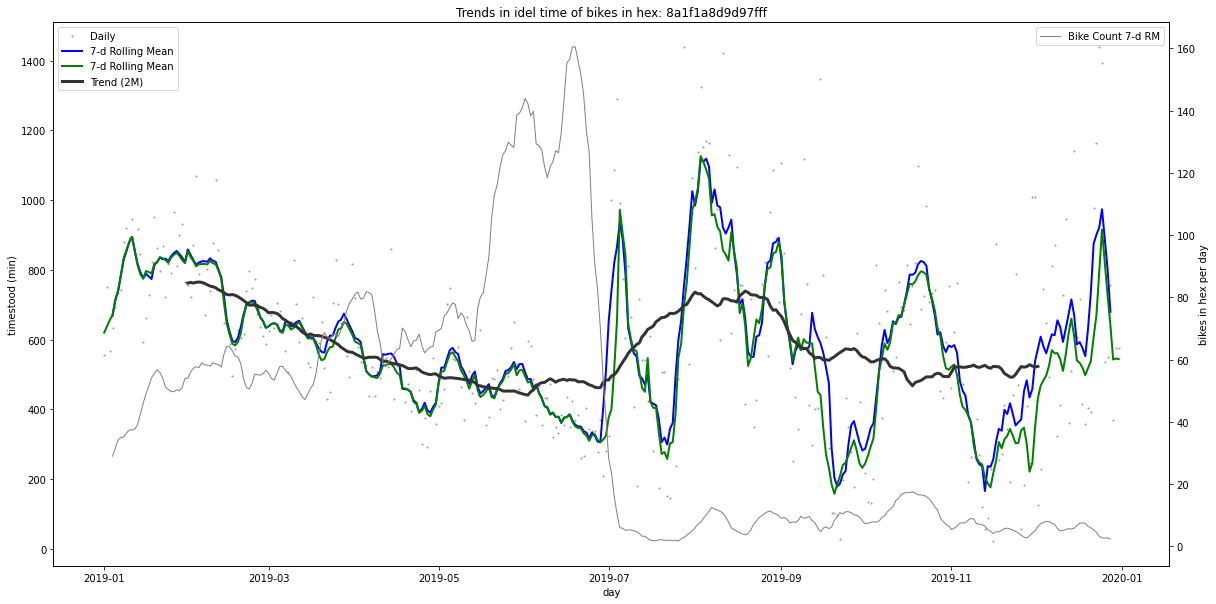

In [134]:
tsdata = fix_missing_values(tsdata)

data_7d_rol = tsdata[data_columns].rolling(window = 7, center = True).mean()
data_2m_rol = tsdata[data_columns].rolling(window = 60, center = True).mean()
data_7d_mean2 = roling_mean_out_of_points(tsdata)


plot_details(tsdata,data_7d_rol,data_2m_rol,data_7d_mean2,hex_id)

# Main2 Plot of all Leipzig !
## all hex df


In [44]:
def all_add_rows_to_days(tsdata,df):
    # iteriere über alle Tage
    for date in tqdm(tsdata.index):
        list = []
        # Adde alle Rows in die List wenn Tag = Tag
        for ind in df.index:
            if date.date() == df['time_start'][ind].date():
                list.append(df['timestood'][ind])
        # Setze Mittelwert für Tag
        if len(list) == 0:
            tsdata['bike_count'][date] = 0
            continue
        else:
            tsdata['bike_count'][date] = len(list)
            tsdata['idle_time'][date] = statistics.mean(list)
    return tsdata

In [45]:
alltsdata = create_tsdata()
alltsdata = all_add_rows_to_days(alltsdata,df)

data_columns = ['idle_time','bike_count']
all_data_7d_rol = alltsdata[data_columns].rolling(window = 7, center = True).mean()
all_data_2m_rol = tsdata[data_columns].rolling(window = 60, center = True).mean()

plot_details(alltsdata,all_data_7d_rol,all_data_2m_rol,hex_id)

  1%|▌                                          | 5/365 [00:30<37:11,  6.20s/it]


KeyboardInterrupt: 

# Testing

# DeTrend the data
## with first order

In [67]:
data_first_order_diff = tsdata[data_columns].diff()

In [68]:
data_first_order_diff

,idle_time,bike_count
date,,
2019-01-01,NaN,NaN
2019-01-02,196.294118,0.0
2019-01-03,-182.335863,14.0
2019-01-04,64.464346,7.0
2019-01-05,59.978469,-5.0
2019-01-06,41.815249,-2.0
2019-01-07,7.131720,5.0
2019-01-08,137.845238,-1.0
2019-01-09,40.988095,1.0


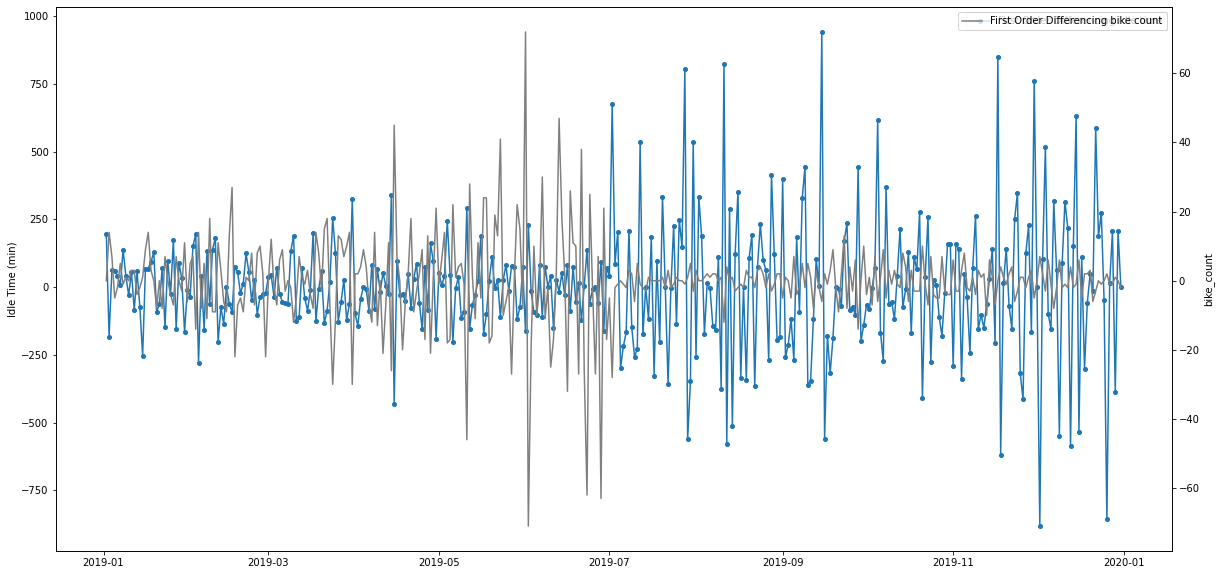

In [73]:
start, end = '2019-01', '2019-12'

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(data_first_order_diff.loc[start:end, 'idle_time'],
marker='o', markersize=4, linestyle='-', label='First Order Differencing idle time')
ax.set_ylabel('Idle Time (min)')
ax.legend();

# Second Y Axis

ax2 = ax.twinx()
ax2.plot(data_first_order_diff.loc[start:end, 'bike_count'], color='grey', label='First Order Differencing bike count')
ax2.set_ylabel('bike_count')
ax2.legend()

plt.show()


<AxesSubplot:xlabel='date'>

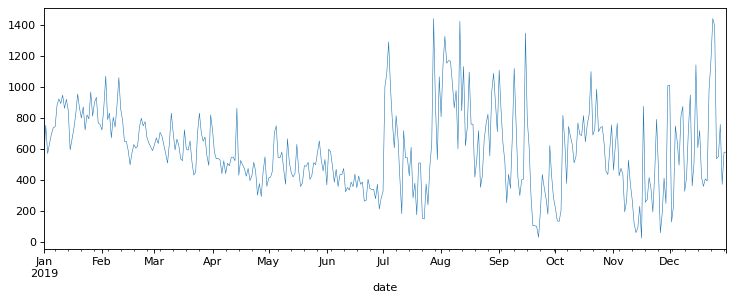

In [74]:
plt.figure(figsize=(11,4), dpi= 80)
tsdata['idle_time'].plot(linewidth = 0.5)

# Autocorellation

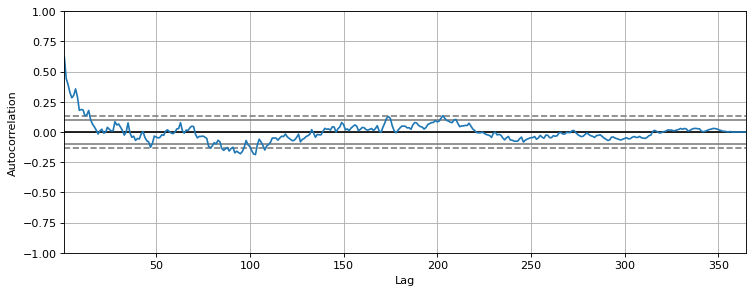

In [76]:
plt.figure(figsize=(11,4), dpi= 80)
pd.plotting.autocorrelation_plot(tsdata.loc['2019-01': '2019-12', 'idle_time']);

In [47]:
lista = [10,12,13,14]
listb = [20]
listab = lista + listb
print(listab)

[10, 12, 13, 14, 20]


In [64]:
meana = np.average(lista)
meanb = np.average(listb)
meanab = np.average(listab)
print(meana)
print(meanb)
print(meanab)

12.25
20.0
13.8


In [55]:
listmp = [12.25,20]
print(statistics.mean(listmp))

16.125


In [56]:
x = np.average(listmp, weights=[len(lista),len(listb)])

In [57]:
x

13.8